## Dynamics

Dynamics | $\partial_{\tau}x_i=$ |
| :--------: | :-------: |
Biochemical | $F -B x_i - R \sum_j A_{ij} x_i x_j$ |
Epidemics | $-B x_i + R \sum_j A_{ij} (1-x_i)x_j$ |
Neuronal | $-B x_i + C \tanh x_i + R \sum_j A_{ij} \tanh x_j$ |
Population | $-B x_i^{b} + R \sum_j A_{ij} x_j^a$ |
Synchronization | $\omega_i + R \sum_j A_{ij} \sin(x_j-x_i)$ |

## Test Experiments

In [34]:
from utils.utils import *
import optuna
from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend
from experiments.experiments_gkan import ExperimentsGKAN
from experiments.experiments_mpnn import ExperimentsMPNN
from train_and_eval import eval_model

storage = JournalStorage(JournalFileBackend("optuna_journal_storage.log"))

### Kuramoto MPNN

In [ ]:
optuna.delete_study(study_name="model-kuramoto-mpnn-test-new-dataset", storage=storage)

In [32]:
config_path = './configs/config_ic5/config_kuramoto.yml'
config = load_config(config_path)
config['epochs'] = 1
config['method'] = 'scipy_solver'
config['atol'] = 1e-5
# config['horizon'] = 5
#config["device"] = "cuda"
#config["data_folder"] = "./data_noise"
#config["noise_scale"] = 0.01 

exp = ExperimentsGKAN(
    config=config,
    n_trials=1,
    study_name='test-new-dataset',
    process_id=0,
)

Processing...


Building the dataset...


Done!


In [33]:
exp.run()

[I 2025-05-16 10:50:32,604] Using an existing study with name 'model-kuramoto-gkan-test-new-dataset' instead of creating a new one.


Trial 17: num params: 150


/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `min_step`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)
[I 2025-05-16 10:51:32,910] Trial 17 finished with value: 0.029602758586406708 and parameters: {'lr': 0.02823825075354001, 'lamb': 1.0, 'batch_size': 16, 'use_orig_reg': False, 'lamb_g_net': 1.5740661645029372e-05, 'lamb_h_net': 0.0006448148975971332, 'grid_size_g_net': 9, 'spline_order_g_net': 3, 'range_limit_g_net': 6, 'mu_1_g_net': 1.0, 'mu_2_g_net': 0.6, 'hidden_dim_g_net': 3, 'grid_size_h_net': 9, 'spline_order_h_net': 1, 'range_limit_h_net': 10, 'mu_1_h_net': 1.0, 'mu_2_h_net': 0.7, 'hidden_dim_h_net': 1}. Best is trial 13 with value: 0.010442144237458706.


### Lower bound

In [3]:
import torch
from models.utils.MPNN import MPNN
from models.baseline.MPNN_ODE import MPNN_ODE

In [8]:
g_symb = lambda x: torch.sin(x[:, 1] - x[:, 0]).unsqueeze(-1)
h_symb = lambda x: 2.0 + 0.5*x[:, 1].unsqueeze(-1)

symb = MPNN(
    g_net = g_symb,
    h_net = h_symb, 
    message_passing=True,
    include_time=False
)

symb_ode = MPNN_ODE(
    conv=symb,
    model_path="./saved_models_optuna/symb_kuramoto",
    adjoint=True,
    integration_method="dopri5"
)

In [9]:
from train_and_eval import eval_model

symb_valid_loss = eval_model(
    model=symb_ode,
    valid_data=exp.valid_set,
    criterion=torch.nn.L1Loss(),
    scaler=exp.scaler,
    inverse_scale=False
)

In [10]:
print(symb_valid_loss)

0.04710772633552551


### Epidemics MPNN

In [10]:
optuna.delete_study(study_name="model-epidemics-mpnn-test-epidemics", storage=storage)

In [ ]:
config_path = './configs/config_ic1/config_epidemics.yml'
config = load_config(config_path)
config['epochs'] = 1

exp = ExperimentsMPNN(
    config=config,
    n_trials=1,
    study_name='test-epidemics',
    process_id=0,
)

Building the dataset...


Processing...
Done!


In [12]:
exp.run()

[I 2025-05-10 10:12:29,327] A new study created in Journal with name: model-epidemics-mpnn-test-epidemics


Epoch: 0 	 Training loss: 0.01012 	 Val Loss: 0.00678 	 Tot Loss: 0.01012
Epoch: 1 	 Training loss: 0.00808 	 Val Loss: 0.00544 	 Tot Loss: 0.00808
Epoch: 2 	 Training loss: 0.00775 	 Val Loss: 0.00617 	 Tot Loss: 0.00775
Epoch: 3 	 Training loss: 0.00734 	 Val Loss: 0.00518 	 Tot Loss: 0.00734
Epoch: 4 	 Training loss: 0.00672 	 Val Loss: 0.00581 	 Tot Loss: 0.00672
Epoch: 5 	 Training loss: 0.00607 	 Val Loss: 0.00549 	 Tot Loss: 0.00607
Epoch: 6 	 Training loss: 0.00591 	 Val Loss: 0.00457 	 Tot Loss: 0.00591
Epoch: 7 	 Training loss: 0.00581 	 Val Loss: 0.00477 	 Tot Loss: 0.00581
Epoch: 8 	 Training loss: 0.00552 	 Val Loss: 0.00428 	 Tot Loss: 0.00552
Epoch: 9 	 Training loss: 0.00528 	 Val Loss: 0.00412 	 Tot Loss: 0.00528

Loading best model found at epoch 9 with val loss 0.004118029959499836
Test loss: 0.0026830669958144426


[I 2025-05-10 10:13:10,063] Trial 0 finished with value: 0.004118029959499836 and parameters: {'lr': 0.0007775093404832605, 'lamb': 0.0, 'batch_size': 16, 'n_hidden_layers_g_net': 2, 'hidden_dims_g_net': 56, 'af_g_net': 'softplus', 'drop_p_g_net': 0.00157630723324707, 'n_hidden_layers_h_net': 2, 'hidden_dims_h_net': 24, 'af_h_net': 'relu', 'drop_p_h_net': 0.00020863994358772403}. Best is trial 0 with value: 0.004118029959499836.


In [13]:
model_path_mpnn = './saved_models_optuna/model-epidemics-mpnn/test-epidemics/0/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=150
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [14]:
mpnn_symb

\sum_{j}( 0.116708815*exp(-x_i*exp(x_j))) - 0.15959646*tanh(log(x_i))

### Neuronal MPNN

In [11]:
optuna.delete_study(study_name="model-neuronal-mpnn-test-neuronal", storage=storage)

In [3]:
config_path = './configs/config_noise/config_neuronal_noise.yml'
config = load_config(config_path)
config['epochs'] = 10

exp = ExperimentsMPNN(
    config=config,
    n_trials=1,
    study_name='test-neuronal',
    process_id=0,
)

In [13]:
exp.run()

[I 2025-05-09 17:07:45,709] A new study created in Journal with name: model-neuronal-mpnn-test-neuronal


Epoch: 0 	 Training loss: 0.15600 	 Val Loss: 0.09005 	 Tot Loss: 0.15600
Epoch: 1 	 Training loss: 0.05407 	 Val Loss: 0.07933 	 Tot Loss: 0.05407
Epoch: 2 	 Training loss: 0.05492 	 Val Loss: 0.00986 	 Tot Loss: 0.05492
Epoch: 3 	 Training loss: 0.02307 	 Val Loss: 0.02946 	 Tot Loss: 0.02307
Epoch: 4 	 Training loss: 0.02772 	 Val Loss: 0.00445 	 Tot Loss: 0.02772
Epoch: 5 	 Training loss: 0.01449 	 Val Loss: 0.02453 	 Tot Loss: 0.01449
Epoch: 6 	 Training loss: 0.01730 	 Val Loss: 0.01004 	 Tot Loss: 0.01730
Epoch: 7 	 Training loss: 0.00799 	 Val Loss: 0.00930 	 Tot Loss: 0.00799
Epoch: 8 	 Training loss: 0.01102 	 Val Loss: 0.00358 	 Tot Loss: 0.01102
Epoch: 9 	 Training loss: 0.00579 	 Val Loss: 0.01125 	 Tot Loss: 0.00579

Loading best model found at epoch 8 with val loss 0.003580222139135003
Test loss: 0.004640685394406319


[I 2025-05-09 17:08:23,447] Trial 0 finished with value: 0.003580222139135003 and parameters: {'lr': 0.022198182869050127, 'lamb': 0.0, 'batch_size': 32, 'n_hidden_layers_g_net': 2, 'hidden_dims_g_net': 32, 'af_g_net': 'softplus', 'drop_p_g_net': 0.0005185973727913854, 'n_hidden_layers_h_net': 1, 'hidden_dims_h_net': 40, 'af_h_net': 'tanh', 'drop_p_h_net': 0.018136511652483187}. Best is trial 0 with value: 0.003580222139135003.


In [5]:
model_path_mpnn = './saved_models_optuna/model-neuronal-mpnn/test-neuronal/0/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=150
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [6]:
mpnn_symb


\sum_{j}( log(log(tanh(x_j/x_i) + 1) + 1)) + 0.14861982/tanh(exp(x_i))

In [18]:
config_path = './configs/config_neuronal.yml'
config = load_config(config_path)
config['epochs'] = 5

exp = ExperimentsGKAN(
    config=config,
    n_trials=1,
    study_name='test-neuronal',
    process_id=0,
)

In [19]:
exp.run()

[I 2025-05-09 14:21:16,405] Using an existing study with name 'model-neuronal-gkan-test-neuronal' instead of creating a new one.


Epoch: 0 	 Training loss: 0.00051 	 Val Loss: 0.00028 	 Tot Loss: 0.00543
Epoch: 1 	 Training loss: 0.00028 	 Val Loss: 0.00014 	 Tot Loss: 0.00507
Epoch: 2 	 Training loss: 0.00016 	 Val Loss: 0.00007 	 Tot Loss: 0.00483
Epoch: 3 	 Training loss: 0.00012 	 Val Loss: 0.00005 	 Tot Loss: 0.00453
Epoch: 4 	 Training loss: 0.00011 	 Val Loss: 0.00004 	 Tot Loss: 0.00443

Loading best model found at epoch 4 with val loss 4.3011452362407e-05
Test loss: 0.000152996537508443


[I 2025-05-09 14:24:39,155] Trial 1 finished with value: 4.3011452362407e-05 and parameters: {'lr': 0.014578887605134958, 'lamb': 1.0, 'batch_size': 32, 'use_orig_reg': True, 'lamb_g_net': 9.722521843140844e-05, 'lamb_h_net': 0.0017345619188380956, 'grid_size_g_net': 9, 'spline_order_g_net': 3, 'range_limit_g_net': 1, 'mu_1_g_net': 0.6, 'mu_2_g_net': 1.0, 'hidden_dim_g_net': 1, 'grid_size_h_net': 7, 'spline_order_h_net': 2, 'range_limit_h_net': 3, 'mu_1_h_net': 1.0, 'mu_2_h_net': 0.7, 'hidden_dim_h_net': 2}. Best is trial 1 with value: 4.3011452362407e-05.


### Biochemical MPNN

In [14]:
optuna.delete_study(study_name="model-biochemical-mpnn-test-biochemical", storage=storage)

In [9]:
config_path = './configs/config_ic1/config_biochemical_mpnn.yml'
config = load_config(config_path)
config['epochs'] = 10

exp = ExperimentsMPNN(
    config=config,
    n_trials=1,
    study_name='test-biochemical',
    process_id=0,
)

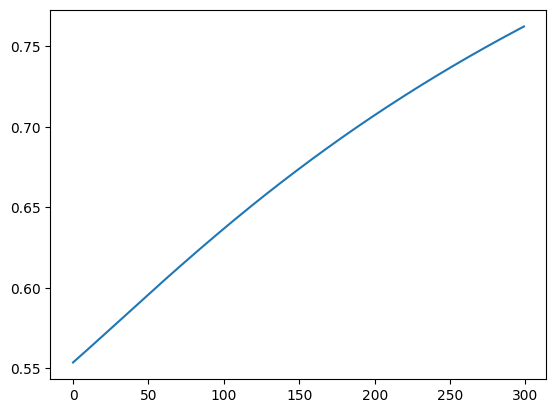

In [17]:
import matplotlib.pyplot as plt
data = exp.training_set.raw_data_sampled.detach().cpu().numpy()

plt.plot(data[0, :, 65, :])

In [16]:
exp.run()

[I 2025-05-09 17:08:40,883] A new study created in Journal with name: model-biochemical-mpnn-test-biochemical


Epoch: 0 	 Training loss: 0.01061 	 Val Loss: 0.00656 	 Tot Loss: 0.01061
Epoch: 1 	 Training loss: 0.00874 	 Val Loss: 0.00552 	 Tot Loss: 0.00874
Epoch: 2 	 Training loss: 0.00779 	 Val Loss: 0.00526 	 Tot Loss: 0.00779
Epoch: 3 	 Training loss: 0.00718 	 Val Loss: 0.00465 	 Tot Loss: 0.00718
Epoch: 4 	 Training loss: 0.00654 	 Val Loss: 0.00416 	 Tot Loss: 0.00654
Epoch: 5 	 Training loss: 0.00580 	 Val Loss: 0.00388 	 Tot Loss: 0.00580
Epoch: 6 	 Training loss: 0.00511 	 Val Loss: 0.00322 	 Tot Loss: 0.00511
Epoch: 7 	 Training loss: 0.00457 	 Val Loss: 0.00279 	 Tot Loss: 0.00457
Epoch: 8 	 Training loss: 0.00387 	 Val Loss: 0.00227 	 Tot Loss: 0.00387
Epoch: 9 	 Training loss: 0.00335 	 Val Loss: 0.00189 	 Tot Loss: 0.00335

Loading best model found at epoch 9 with val loss 0.001890188199467957
Test loss: 0.0018362425034865737


[I 2025-05-09 17:09:18,946] Trial 0 finished with value: 0.001890188199467957 and parameters: {'lr': 0.0011331826087084096, 'lamb': 0.0, 'batch_size': 16, 'n_hidden_layers_g_net': 2, 'hidden_dims_g_net': 24, 'af_g_net': 'tanh', 'drop_p_g_net': 0.012105133221616455, 'n_hidden_layers_h_net': 1, 'hidden_dims_h_net': 16, 'af_h_net': 'softplus', 'drop_p_h_net': 0.01289533029330185}. Best is trial 0 with value: 0.001890188199467957.


In [11]:
model_path_mpnn = './saved_models_optuna/model-biochemical-mpnn/test-biochemical/0/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [12]:
mpnn_symb

\sum_{j}( -0.15344319*x_i*exp(x_j)) - 0.14971581*x_i + 0.87793374

In [23]:
config_path = './configs/config_biochemical.yml'
config = load_config(config_path)
config['epochs'] = 5

exp = ExperimentsGKAN(
    config=config,
    n_trials=1,
    study_name='test-biochemical',
    process_id=0,
)

In [24]:
exp.run()

[I 2025-05-09 14:43:07,097] A new study created in Journal with name: model-biochemical-gkan-test-biochemical


Epoch: 0 	 Training loss: 0.00011 	 Val Loss: 0.00007 	 Tot Loss: 0.00409
Epoch: 1 	 Training loss: 0.00010 	 Val Loss: 0.00006 	 Tot Loss: 0.00416
Epoch: 2 	 Training loss: 0.00010 	 Val Loss: 0.00005 	 Tot Loss: 0.00426
Epoch: 3 	 Training loss: 0.00009 	 Val Loss: 0.00005 	 Tot Loss: 0.00439
Epoch: 4 	 Training loss: 0.00009 	 Val Loss: 0.00004 	 Tot Loss: 0.00456

Loading best model found at epoch 4 with val loss 4.181330223218538e-05
Test loss: 2.1962674509268254e-05


[I 2025-05-09 14:45:45,104] Trial 0 finished with value: 4.181330223218538e-05 and parameters: {'lr': 0.0029212460068246317, 'lamb': 1.0, 'batch_size': 16, 'use_orig_reg': True, 'lamb_g_net': 0.0012543290658560168, 'lamb_h_net': 1.2825379943612229e-06, 'grid_size_g_net': 8, 'spline_order_g_net': 1, 'range_limit_g_net': 1, 'mu_1_g_net': 0.7, 'mu_2_g_net': 0.9, 'hidden_dim_g_net': 3, 'grid_size_h_net': 6, 'spline_order_h_net': 2, 'range_limit_h_net': 3, 'mu_1_h_net': 0.6, 'mu_2_h_net': 0.5, 'hidden_dim_h_net': 3}. Best is trial 0 with value: 4.181330223218538e-05.


### Population MPNN

In [5]:
config_path = './configs/config_ic5/config_population_mpnn.yml'
config = load_config(config_path)
config['epochs'] = 1

exp = ExperimentsMPNN(
    config=config,
    n_trials=1,
    study_name='test-population',
    process_id=0,
)

Processing...
Done!


Building the dataset...


In [6]:
exp.training_set.raw_data_sampled.max().item()

6.902940273284912

In [32]:
import matplotlib.pyplot as plt

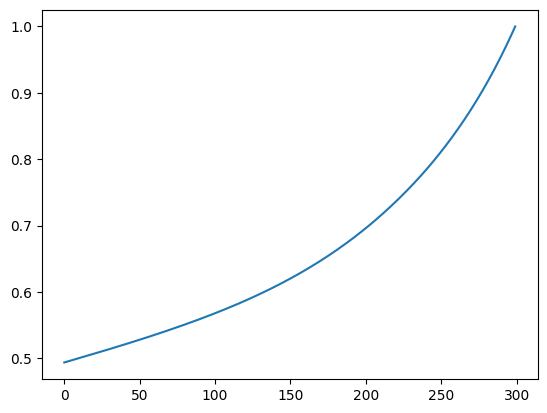

In [40]:
data = exp.training_set.raw_data_sampled.detach().cpu().numpy()
plt.plot(data[1, :, 55, :])

In [ ]:
exp.run()

[I 2025-05-15 13:46:17,592] Using an existing study with name 'model-population-mpnn-test-population' instead of creating a new one.


Trial 1: num params: 1898


[I 2025-05-15 13:46:36,706] Trial 1 finished with value: 0.004098234232515097 and parameters: {'lr': 0.007960010461891508, 'lamb': 0.0, 'batch_size': 32, 'n_hidden_layers_g_net': 2, 'hidden_dims_g_net': 40, 'af_g_net': 'relu', 'drop_p_g_net': 0.08145742288419544, 'n_hidden_layers_h_net': 1, 'hidden_dims_h_net': 32, 'af_h_net': 'tanh', 'drop_p_h_net': 0.0061770830010497045}. Best is trial 1 with value: 0.004098234232515097.


: 

## Symbolic reg

### Utils

In [4]:
from models.utils.MPNN import MPNN
from models.baseline.MPNN_ODE import MPNN_ODE
from train_and_eval import eval_model
from datasets.SyntheticData import SyntheticData
from sympy import symbols, sin, summation, simplify
import networkx as nx
from torch_geometric.utils import from_networkx
from utils.utils import integrate
from torch_geometric.data import Data

In [5]:
def get_model(g, h, message_passing=True, include_time=False, atol=1e-5, rtol=1e-3, integration_method = 'scipy_solver'):
    conv = MPNN(
        g_net = g,
        h_net = h, 
        message_passing=message_passing,
        include_time=include_time
    )
    
    symb = MPNN_ODE(
        conv=conv,
        model_path="./saved_models_optuna/tmp_symb",
        adjoint=True,
        integration_method=integration_method,
        atol=atol,
        rtol=rtol
    )
    
    return symb


def get_symb_test_error(g_symb, h_symb, test_set, message_passing=False, include_time=False, atol=1e-5, rtol=1e-3, scaler = None, inverse_scale=False):
    
    # total_len = len(dataset)
    # test_set = dataset[int(0.9*total_len):]
    
    symb = get_model(
        g=g_symb,
        h=h_symb,
        message_passing=message_passing,
        include_time=include_time,
        atol=atol,
        rtol=rtol
    )
    
    test_loss = eval_model(
        model=symb,
        valid_data=test_set,
        criterion=torch.nn.L1Loss(),
        scaler=scaler,
        inverse_scale=inverse_scale
    )
    
    return test_loss


def get_test_set(dynamics, seed=12345, device='cuda', input_range = (0, 1), **integration_kwargs):
    graph = nx.barabasi_albert_graph(100, 3, seed=seed)
    edge_index = from_networkx(graph).edge_index
    edge_index = edge_index.to(torch.device(device))
    rng = np.random.default_rng(seed=seed)
    
    data, t = integrate(
        input_range=input_range,
        t_span = [0, 1],
        t_eval_steps=300,
        dynamics=dynamics,
        device=device,
        graph=graph,
        rng = rng,
        **integration_kwargs
    )
    
    snapshot = Data(
        x = data[0].unsqueeze(0),
        y = data[1:],
        edge_index=edge_index,
        edge_attr=None,
        t_span = t
    )
    
    return [snapshot]
    
    

### LB losses


In [27]:
kur_config = load_config("./configs/config_ic1/config_kuramoto.yml")

KUR = get_test_set(
    dynamics=kur_config['name'],
    seed = 12345,
    device=kur_config['device'],
    input_range=kur_config['input_range'],
    **kur_config['integration_kwargs']    
)

g_symb = lambda x: torch.sin(x[:, 1] - x[:, 0]).unsqueeze(-1)
h_symb = lambda x: 2.0 + 0.5 * x[:, 1].unsqueeze(-1)

test_loss = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=KUR,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
)

print(f"Kuramoto: {test_loss}")


Kuramoto: 7.834048301447183e-05


In [26]:
epid_config = load_config("./configs/config_ic1/config_epidemics.yml")

EPID = get_test_set(
    dynamics=epid_config['name'],
    seed = 12345,
    device=epid_config['device'],
    input_range=epid_config['input_range'],
    **epid_config['integration_kwargs']    
)

g_symb = lambda x: 0.5*x[:, 1].unsqueeze(-1) * (1 - x[:, 0].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(1) - 0.5 * x[:, 0].unsqueeze(-1)

test_loss = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=EPID,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
)

print(f"Epidemics: {test_loss}")


Epidemics: 1.2377448911138345e-05


In [25]:
pop_config = load_config("./configs/config_ic1/config_population.yml")

POP = get_test_set(
    dynamics=pop_config['name'],
    seed = 12345,
    device=pop_config['device'],
    input_range=pop_config['input_range'],
    **pop_config['integration_kwargs']    
)

g_symb = lambda x: 0.2*torch.square(x[:, 1].unsqueeze(-1))
h_symb = lambda x: -0.5 * torch.square(x[:, 0].unsqueeze(-1)) + x[:, 1].unsqueeze(1) 

test_loss = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=POP,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
)

print(f"Population: {test_loss}")


Population: 1.7622913219383918e-05


### Kuramoto GKAN

#### IC=1

#### IC=3

In [22]:
model_path_gkan = './saved_models_optuna/model-kuramoto-gkan/kuramoto-gkan_3/0/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=9999,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [23]:
gkan_symb

\sum_{j}( -0.50056*sin(x_i - x_j)) + 2.0027082 - 0.013696434*exp(-x_i)

In [5]:
g_symb = lambda x: torch.sin(x[:, 0] - x[:, 1]).unsqueeze(-1)
h_symb = lambda x: 2.0027082 - 0.50056 * x[:, 1].unsqueeze(-1) - 0.013696434 * (torch.exp(-x[:, 0])).unsqueeze(-1)

dataset = SyntheticData(
    root = './data',
    dynamics='Kuramoto',
    horizon=15
)

print(get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    dataset=dataset,
    message_passing=True,
    include_time=False
))

6.243983807507902e-05


#### IC=5

### Epidemics GKAN

#### IC=1

#### IC=3

In [6]:
model_path_gkan = './saved_models_optuna/model-epidemics-gkan/epidemics_gkan_/0/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=9999,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [7]:
gkan_symb

\sum_{j}( 0.5001196*x_j*(0.9996479 - x_i)) - 0.49795532*x_i

In [7]:
g_symb = lambda x: 0.5001196*x[:, 1].unsqueeze(-1) * (0.9996479 - x[:, 0].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(1) - 0.49795532 * x[:, 0].unsqueeze(-1)

dataset = SyntheticData(
    root = './data',
    dynamics='Epidemics',
    horizon=15
)

print(get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    dataset=dataset,
    message_passing=True,
    include_time=False
))

2.2776461264584213e-05


#### IC=5

### Neuronal GKAN

#### IC=1

#### IC=3

In [10]:
model_path_gkan = './saved_models_optuna/model-neuronal-gkan/neuronal_gkan_/1/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=9999,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [11]:
gkan_symb

\sum_{j}( 0.29298076*tanh(x_j)) - 0.18231857*x_i + 0.238917109306232

#### IC=5

### Biochemical GKAN

#### IC=3


In [4]:
model_path_gkan = './saved_models_optuna/model-biochemical-gkan/biochemical_gkan_2/2/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=250
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=9999,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [5]:
gkan_symb

\sum_{j}( -0.4994442*x_i*x_j) + log(2.6236862 - x_i)

#### IC = 1

In [37]:
model_path_gkan = "./saved_models_optuna/model-biochemical-gkan/biochemical_gkan_ic1_s5/0/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=9999,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [38]:
gkan_symb

\sum_{j}( -0.5005216*x_i*x_j) + sin(tanh(x_i) + 1.8310032)

#### IC=5

### Population

#### IC=1

#### IC=3

In [2]:
model_path_gkan = "./saved_models_optuna/model-population-gkan/population_gkan/1/gkan"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=250
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=9000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [3]:
gkan_symb

\sum_{j}( x_j - log(x_j + 1)) - 0.44236052*x_i

#### IC=5